In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset =  tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
for image_batch, label_batch in dataset.take(1):
    print (image_batch[0].numpy)
    print (label_batch.numpy())

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[181., 177., 191.],
        [176., 172., 186.],
        [183., 179., 193.],
        ...,
        [209., 207., 218.],
        [207., 205., 216.],
        [206., 204., 215.]],

       [[173., 169., 183.],
        [169., 165., 179.],
        [178., 174., 188.],
        ...,
        [202., 200., 211.],
        [204., 202., 213.],
        [207., 205., 216.]],

       [[182., 178., 192.],
        [174., 170., 184.],
        [178., 174., 188.],
        ...,
        [192., 190., 201.],
        [194., 192., 203.],
        [198., 196., 207.]],

       ...,

       [[137., 133., 147.],
        [120., 116., 130.],
        [ 89.,  85.,  99.],
        ...,
        [150., 144., 158.],
        [127., 121., 135.],
        [122., 116., 130.]],

       [[124., 120., 134.],
        [105., 101., 115.],
        [124., 120., 134.],
        ...,
        [187., 181., 195.],
        [152., 146., 160.],
       

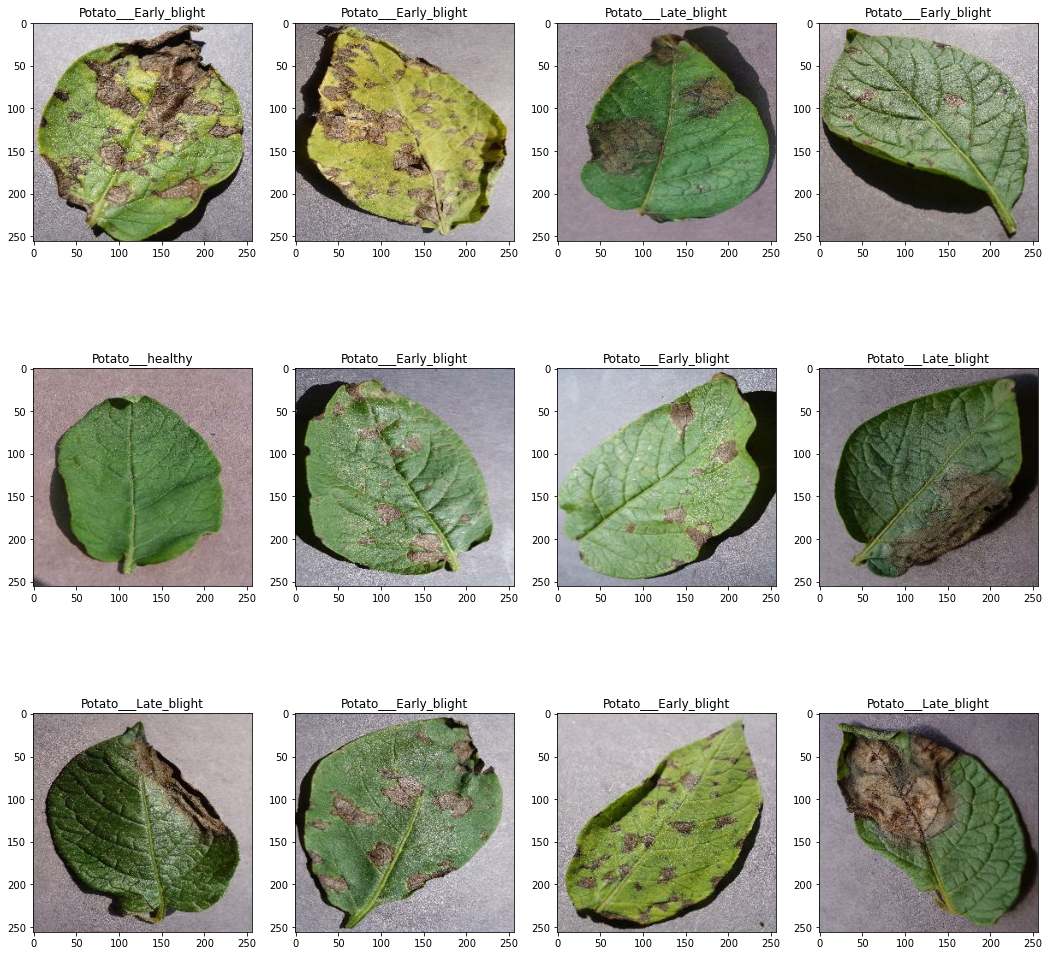

In [8]:
plt.figure(figsize = (18,18))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("on")

In [9]:
#80% ==> tranning
#20% ==> 10% validation, 10% test

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds,train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
#Pre-processed
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
#Gererate new samples
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
#CNN
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
#Set up layer
model = models.Sequential([
   
    resize_and_rescale,
    
    data_augmentation,
    
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape ),# 32 layer:Trial and Error to detect edges
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax'),#n_classes:3 neuron,softmax : normalize the probability of your classes
])
model.build(input_shape = input_shape)

In [25]:
model.summary()
#Trainable params: 183,747

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [26]:
#compile using optimizer "adam"
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [27]:
#Tranning network
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
)

Epoch 1/50
54/54 [==============================] - 52s 711ms/step - loss: 0.9004 - accuracy: 0.5133 - val_loss: 0.9093 - val_accuracy: 0.4792
Epoch 2/50
54/54 [==============================] - 27s 497ms/step - loss: 0.7112 - accuracy: 0.6562 - val_loss: 0.7040 - val_accuracy: 0.6771
Epoch 3/50
54/54 [==============================] - 30s 561ms/step - loss: 0.4859 - accuracy: 0.7951 - val_loss: 0.5574 - val_accuracy: 0.7917
Epoch 4/50
54/54 [==============================] - 30s 562ms/step - loss: 0.4116 - accuracy: 0.8380 - val_loss: 0.4280 - val_accuracy: 0.8073
Epoch 5/50
54/54 [==============================] - 30s 559ms/step - loss: 0.3535 - accuracy: 0.8513 - val_loss: 0.6269 - val_accuracy: 0.7552
Epoch 6/50
54/54 [==============================] - 30s 561ms/step - loss: 0.2800 - accuracy: 0.8843 - val_loss: 0.2497 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 30s 559ms/step - loss: 0.1978 - accuracy: 0.9282 - val_loss: 0.1147 - val_accuracy: 0.9688

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 192ms/step - loss: 0.0227 - accuracy: 0.9922


In [29]:
scores

[0.022711066529154778, 0.9921875]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
acc =  history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss =  history.history['loss']
val_loss =  history.history['val_loss']

Text(0.5, 1.0, 'Trainning and Validation Loss')

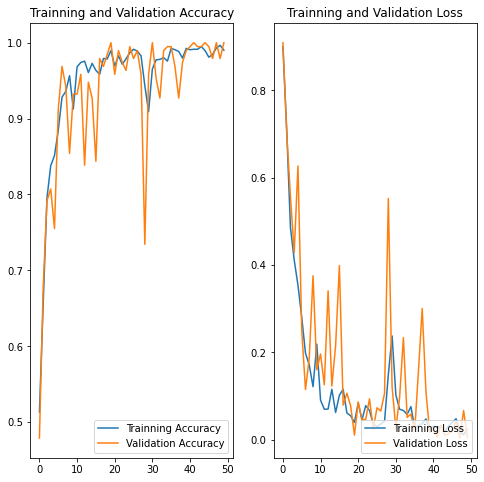

In [34]:
#Plot trainning history on graph
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Trainning Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Trainning and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Trainning Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Trainning and Validation Loss')

First image to predict
First image label Potato___healthy
predicted label: Potato___healthy


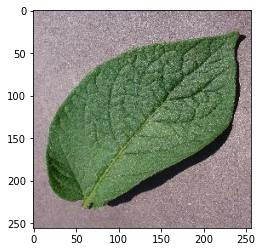

In [35]:
#Make prediction/inference on sample images

import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = (images_batch[0].numpy().astype('uint8'))#RGB
    first_label = labels_batch[0]
    
    print('First image to predict')
    plt.imshow(first_image)
    print("First image label",class_names[first_label])
    
    batch_prediction = model.predict(images_batch) #predict for first 32 image
    print('predicted label:',class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)# Creae a batch
    
    predictions = model.predict(img_array)
     
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

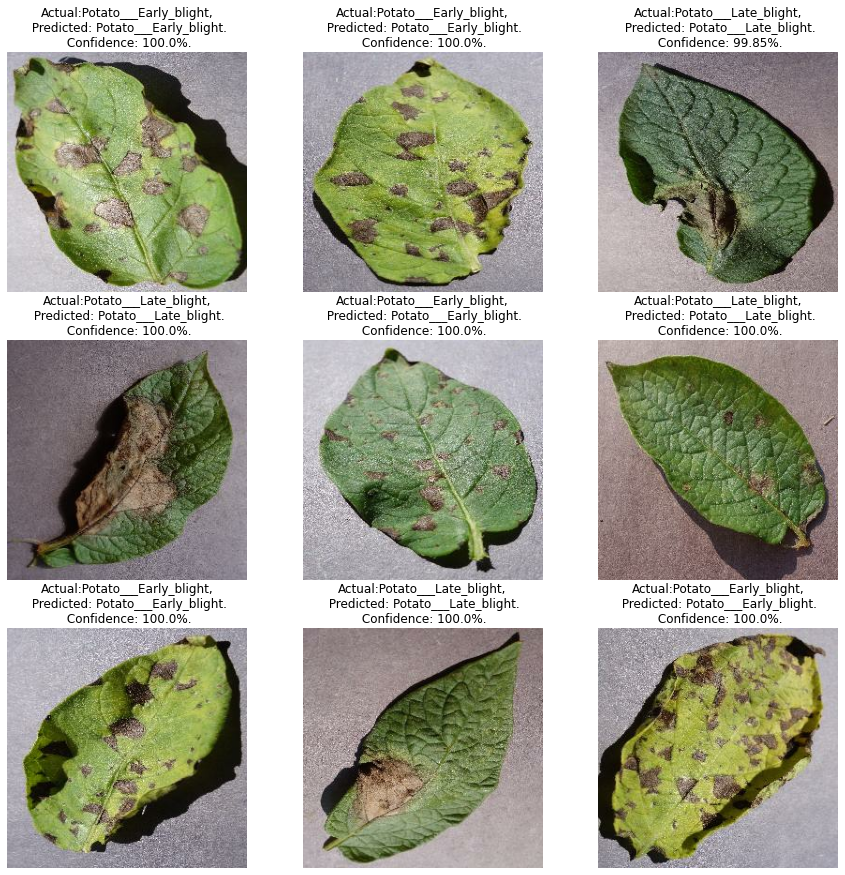

In [37]:
plt.figure(figsize = (15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%.")
        
        plt.axis('off')

In [39]:
import os
model_version =  max([int (i) for i in os.listdir("../saved_model")])+1
model.save(f"../saved_model/{model_version}")

INFO:tensorflow:Assets written to: ../saved_model/3\assets
